# Bayesian Optimization with $\textbf{sklearn}$


The basic idea behind Bayesian optimisation is that we have a black box, expensive to evaluate function $f(x)$, called the **objective** that we want to optimise over some domain, the **search space**.
The objective function $f$ is a black-box because it is characterised:
1. No access to gradients
2. Evaluation is expensive
3. Observations are corrupted by additional noise

 Bayesian optimisation is a sequential algorithm that works in the following way.

1. Initial sample of input values - potentially through some optimal experimental design.
2. Evaluate the black box function $f(x)$
3. Train the GP
4. Calculate the acquisition function $\alpha(x)$
5. Identify next step by optimising the acquisition function

Hence we understand that this algorithm has two main aspects.
1. What is our **Model**: Gaussian processes, Bayesian Neural Networks, Variational Auto Encoders, Trees.
2. What is our **Exploration Strategy**, given that model: Acquisition function that maps the model to the next query point.

#### Acquisition function

The role of the acquisition function is to balance the exploration (choosing points far away from the current optimum to avoid local optima) and exploitation (choosing points very close to the current optimum to find a better solution).
A common acquisition function would be: $\alpha(x) = f(x)-k\cdot\text{sd}(f(x))$. The hyperparameter $k$ is what controls this exploration vs exploitation balance.
- Small $k$ -> Local Optimisation
- Large $k$ -> Global Optimisation
In general the acquisition function tries to solve the problem:

$$
x_{\text{next}} = \text{query}(M,D) = \text{argmax}_{x\in X} a(x; M,D)
$$
Where $M$ is the model and $D$ the know datapoints.

Popular acquisition function are:
- Probability of Improvement (PI)
- Expected Improvement (EI)
- Upper (Lower) Confidence Bound (UCB)
- Thomson Sampler


Therefore, Bayesian optimisation can be boiled down to 4 main spaces.

- The **objective** function - the one we are trying to optimise
- The **surrogate** function - the one we use to model the objective function (Gaussian Process)
- The **acquisition** function - the one we use to choose our next step
- The **search space** - the space over which all of the above functions are defined.

##### Note

At the *heart* of Bayesian optimisation is the surrogate model, and the most used surrogate model is the Gaussian Process. This is because the GP has some very nice mathematical properties that help us calculate the resulting predictive distribution fairly quickly. However this is **not** the only possible model. Other models that are used in the literature are:

- Trees
- Response Surfaces
- Support Vector Machines
- Bayesian Neural Networks


In [46]:
import math
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings("ignore") # Not the best

plt.style.use('fivethirtyeight')

# 1D function optimization with noise

In [47]:
def objective(x, noise_scale=0.1):
  noise = np.random.normal(loc=0, scale=noise_scale)
  return (x**2 * math.sin(5 * math.pi *  x)**6.0) + noise
  # return (x*np.sin(10*x)) + noise

In [48]:
X_ax = np.arange(0,1 , 0.01).reshape(-1,1)
y_ax = np.array([objective(x, 0) for x in X_ax])
ynoise = [objective(x) for x in X_ax]

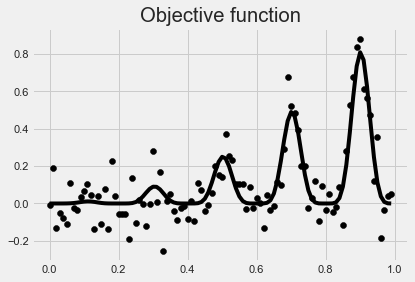

In [49]:
plt.scatter(X_ax, ynoise, color='black')
plt.plot(X_ax, y_ax, color='black')
plt.title("Objective function")
plt.savefig("./figs/bo_objective.png")
plt.show()


# Helpers

In [39]:
def objective(x, noise_scale=0.1):
  noise = np.random.normal(loc=0, scale=noise_scale)
  return (x**2 * math.sin(5 * math.pi * x)**6.0) + noise
  # return (x*np.sin(10*x)) + noise

def surrogate(model, X):
  return model.predict(X, return_std=True)

def plot(X, y, model):
  X_ax = np.arange(0, 1 , 0.01).reshape(-1,1)
  y_ax = np.array([objective(x, 0) for x in X_ax])

  plt.scatter(X, y, color='red', s=90)
  plt.plot(X_ax, y_ax, color='black')
  yhat_ax, std_hat = surrogate(model, X_ax)
  plt.plot(X_ax, yhat_ax)
  plt.title("Initial Sampling")
  plt.fill_between(
    X_ax.reshape(-1,),
    yhat_ax.reshape(-1,) - 1.96 * std_hat,
    yhat_ax.reshape(-1,) + 1.96 * std_hat,
    alpha=0.5,
    label=r"95% confidence interval",
  )
  plt.savefig("./figs/bo_initial.png")
  plt.show()


def acq_pi(X, Xsamples, model):
  yhat, _ = surrogate(model, X)
  best = max(yhat) # calculate the best so far

  mu, std = surrogate(model, Xsamples)
  mu = mu[:, 0]
  gamma = (mu - best) / (std + 1E-9)
  probs = norm.cdf(gamma) # add a very small number to std to avoid dividing with 0
  return probs

def acq_ei(X, Xsamples, model):
  yhat, _ = surrogate(model, X)
  best = max(yhat) # calculate the best so far

  mu, std = surrogate(model, Xsamples)
  mu = mu.reshape(-1,1)[:, 0]
  gamma = (mu-best)/(std + 1E-9) # add a very small number to std to avoid dividing with 0
  probs = std * (gamma * norm.cdf(gamma)) + norm.pdf(gamma)
  return probs

def opt_acq(X, y, model, acq=acq_pi):
  Xsamples = np.random.random(1000).reshape(-1, 1) # can be improved upon
  scores = acq(X, Xsamples, model)
  ix = np.argmax(scores)
  return Xsamples[ix, 0]

# Optimization loop

In [40]:
def random_start_loop(n=5, noise=0.01, kernel=None, latin=False):
  X = (np.random.random(n).reshape(-1,1))*(1-latin) + (np.linspace(0., 1., num=n).reshape(-1,1))*(latin)
  y = np.array([objective(x, noise) for x in X]).reshape(-1,1) # Evaluation with noise
  model = GaussianProcessRegressor(kernel=kernel)
  model.fit(X, y)
  return X, y, model

def bo_loop(n, X, y, model, noise, acq):
  for i in range(n):
    x = opt_acq(X=X, y=y, model=model, acq=acq)
    actual = objective(x, noise)
    est, _ = surrogate(model, [[x]])

    X = np.vstack((X, [[x]]))
    y = np.vstack((y, [[actual]]))
    model.fit(X, y)
  return X, y, model

### Initial sampling

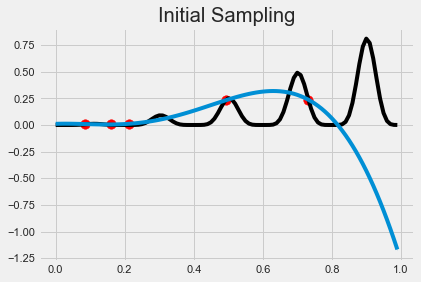

In [45]:
kernel = None
# kernel = ConstantKernel(constant_value=2)
# kernel = WhiteKernel(noise_level=0.5)
# kernel = 1. * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))
# kernel = 1. * Matern(length_scale=1., nu=3/2)
noise_lvl = 0.01
X_init, y_init, model = random_start_loop(n=5, noise=noise_lvl, kernel=kernel, latin=False)
plot(X_init, y_init, model)

### Optimization loop

In [26]:
# X, y, model = bo_loop(n=50, X=X_init, y=y_init, model=model, noise=noise_lvl, acq=acq_ei)
# plot(X, y, model)
# print('Best Result: x=%.3f, y=%.3f' % (X[np.argmax(y)], y[np.argmax(y)]))
# print('Actual Best: x=%.3f, y=%.3f' % (X_ax[np.argmax(y_ax)], y_ax[np.argmax(y_ax)]))

### Bootstrap

In this section I am running $5, 10, 50, 100, 200$ experiments with $150$ random starts of the BO process. After each run I gathered the best $X$ and then I plotted the histogram of each experiment.
We see that even with just $5$ experiments, there is a good chance that we find the maximum of this specific objective function.

In [27]:
runs = 50
n = [5, 10, 50, 100, 200]
best_x_matrix = []
noise_lvl = 0.01

for i in tqdm(range(runs)):

  kernel = None
  X_init, y_init, model = random_start_loop(n=5, noise=noise_lvl, kernel=kernel, latin=False)

  best_x_row = []
  for j in n:
    X, y, model = bo_loop(n=j, X=X_init, y=y_init, model=model, noise=noise_lvl, acq=acq_ei)
    best_x_row.append(*X[np.argmax(y)])
  best_x_matrix.append(best_x_row)

best_x_matrix = pd.DataFrame(best_x_matrix, columns=n)
best_x_matrix['id'] = list(range(0, runs))

100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


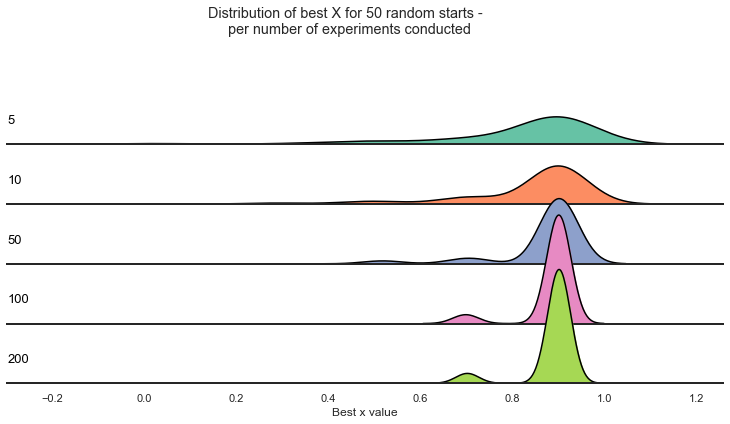

In [31]:
import seaborn as sns
df = pd.melt(best_x_matrix, id_vars='id', value_vars=n,
             var_name='experiments', value_name='best_x')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)

g = sns.FacetGrid(df, palette=palette, row="experiments", hue="experiments", aspect=9, height=1.2)

g.map_dataframe(sns.kdeplot, x="best_x", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="best_x", color='black')

def label(x, color, label):
  ax = plt.gca()
  ax.text(0, .2, label, color='black', fontsize=13,
          ha="left", va="center", transform=ax.transAxes)

g.map(label, "experiments")

g.fig.subplots_adjust(hspace=-.5)

g.set_titles("")
g.set(yticks=[], xlabel="Best x value", ylabel="")
g.despine(left=True)
plt.suptitle(f"Distribution of best X for {runs} random starts - \n per number of experiments conducted", y=0.98)
plt.savefig("./figs/bo_bootstrap.png", format='png')
plt.show()
